In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import constants
import seaborn as sns
import functions
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    log_loss,
    PrecisionRecallDisplay,
    precision_recall_curve,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from category_encoders import TargetEncoder
import xgboost as xgb
import shap

In [40]:
import importlib

importlib.reload(functions)

<module 'functions' from 'c:\\Users\\balsevt\\python\\m3s4\\functions.py'>

In [22]:
import importlib

importlib.reload(constants)

<module 'constants' from 'c:\\Users\\balsevt\\python\\m3s4\\constants.py'>

In [4]:
df_app = pd.read_parquet(r"data\train\df_app.parquet", engine="pyarrow")
df_bur = pd.read_parquet(r"data\train\df_bur.parquet", engine="pyarrow")
df_bur_bal = pd.read_parquet(r"data\train\df_bur_bal.parquet", engine="pyarrow")
df_prev_app = pd.read_parquet(r"data\train\df_prev_app.parquet", engine="pyarrow")
df_cash = pd.read_parquet(r"data\train\df_cash.parquet", engine="pyarrow")
df_inst = pd.read_parquet(r"data\train\df_inst.parquet", engine="pyarrow")
df_cred = pd.read_parquet(r"data\train\df_cred.parquet", engine="pyarrow")

### EDA

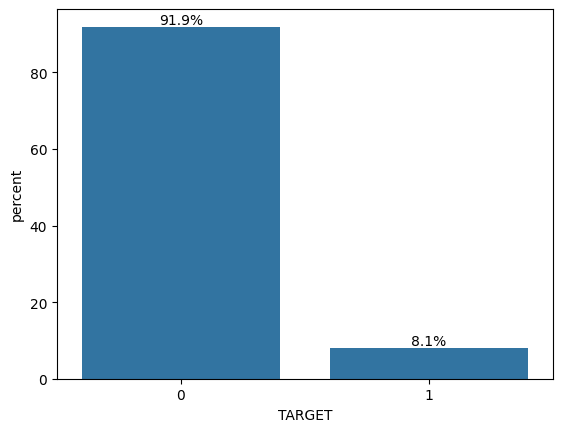

In [5]:
sns.countplot(df_app.fillna(-1), x="TARGET", stat="percent")
functions.add_labels(fmt="%2.1f%%")

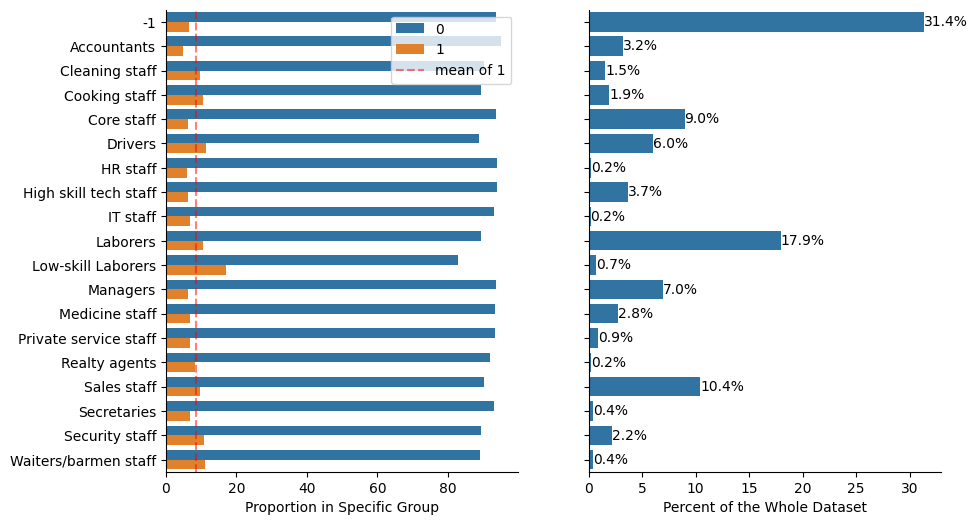

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
functions.norm_plot(df_app.fillna(-1), "OCCUPATION_TYPE", "TARGET", ax=ax)

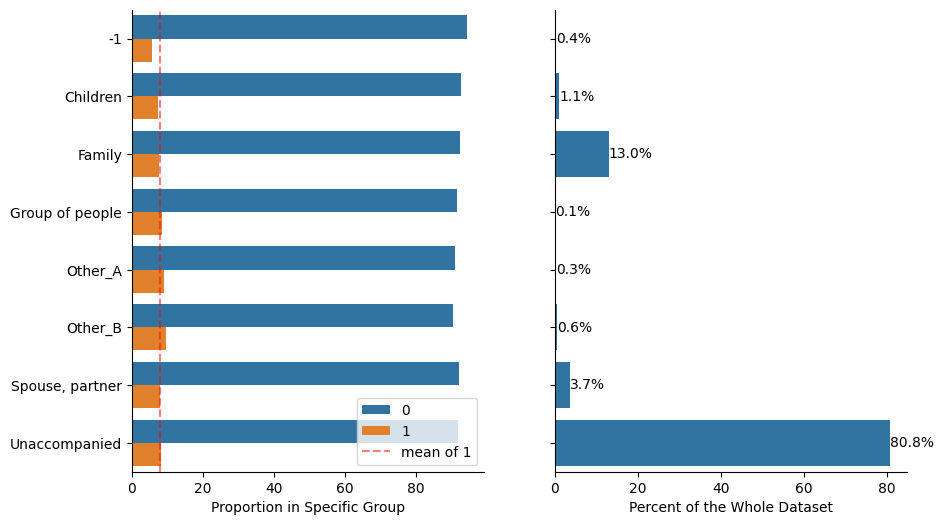

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
functions.norm_plot(df_app.fillna(-1), "NAME_TYPE_SUITE", "TARGET", ax=ax)

count     292135
unique         5
top           -1
freq      199858
Name: FONDKAPREMONT_MODE, dtype: int64

FONDKAPREMONT_MODE
True     0.684129
False    0.315871
Name: proportion, dtype: float64

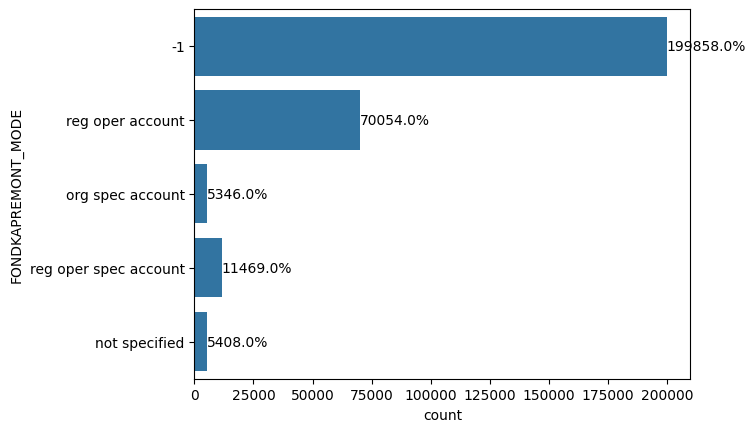

In [8]:
col = "FONDKAPREMONT_MODE"
sns.countplot(df_app.fillna(-1), y=col)
functions.add_labels(fmt="%2.1f%%")

display(df_app.fillna(-1)[col].describe())
df_app[col].isna().value_counts(normalize=True)

count    292135.000000
mean      63887.524867
std      141336.381501
min      -17912.000000
25%       -2760.000000
50%       -1214.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

DAYS_EMPLOYED
False    1.0
Name: proportion, dtype: float64

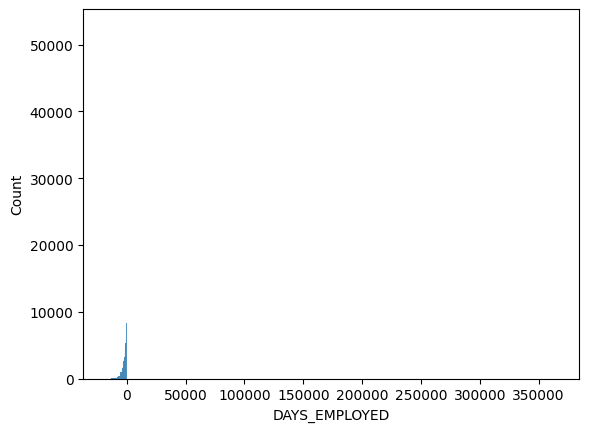

In [9]:
col = "DAYS_EMPLOYED"
sns.histplot(df_app[col])
display(df_app[col].describe())
df_app[col].isna().value_counts(normalize=True)

In [10]:
col = "DAYS_EMPLOYED"
(df_app[df_app[col] > 0][col] == 365243).value_counts()

DAYS_EMPLOYED
True    52663
Name: count, dtype: int64

In [11]:
for col in constants.AVG_MEDI_MODE_COLS:
    na_prop = df_app[col].isna().value_counts(normalize=True)[True]
    if na_prop < 0.4:
        print(f"{col} has little NAs")
print("All done")

All done


### Modelling

In [12]:
binary_imputer = SimpleImputer(missing_values="XNA", strategy="most_frequent")
binary_encoder = OneHotEncoder(
    drop="if_binary", handle_unknown="ignore", sparse_output=False
)
binary_pipe = Pipeline(
    [
        ("imputer", binary_imputer),
        ("encoder", binary_encoder),
    ]
)
target_imputer = SimpleImputer(
    missing_values="XNA", strategy="constant", fill_value=None
)
target_encoder = TargetEncoder(handle_missing="value")
target_pipe = Pipeline(
    [
        ("imputer", target_imputer),
        ("encoder", target_encoder),
    ]
)
binary_features = constants.BINARY_COLUMNS_ENCODE
target_features = (
    constants.CATEGORICAL_HIGH_CARDINAL_COLUMNS
    + constants.CATEGORICAL_LOW_CARDINAL_COLUMNS
    + constants.CATEGORICAL_MODE_COLS
)
passthrough_features = (
    constants.BINARY_COLUMNS_PASSTHROUGH
    + constants.CONTINUOUS_COLUMNS
    + constants.ORDINAL_COLUMNS
)
preprocessor = ColumnTransformer(
    [
        ("binary_pipe", binary_pipe, binary_features),
        ("target_pipe", target_pipe, target_features),
        ("passthrough", "passthrough", passthrough_features),
        ("drop", "drop", constants.DROP_COLUMNS),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [26]:
# For better analysis, make days always positive rather than always negative
df_app_days_tf = df_app.copy()
df_app_days_tf[constants.DAYS_COLUMNS] = df_app_days_tf[constants.DAYS_COLUMNS] * -1
df_train, df_valid = train_test_split(
    df_app_days_tf, test_size=0.2, stratify=df_app["TARGET"], random_state=42
)
X_train = df_train.drop(columns="TARGET")
y_train = df_train["TARGET"]
X_valid = df_valid.drop(columns="TARGET")
y_valid = df_valid["TARGET"]

X_train_tf = preprocessor.fit_transform(X_train, y_train)
X_valid_tf = preprocessor.transform(X_valid)

Naive log loss baseline - predict each as having the mean probability.

In [27]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
losses = list()
X = df_app_days_tf.drop(columns="TARGET")
y = df_app_days_tf["TARGET"]
for train_idx, eval_idx in cv.split(X, y):
    X_cv_train, y_cv_train = X.iloc[train_idx], y.iloc[train_idx]
    X_cv_eval, y_cv_eval = X.iloc[eval_idx], y.iloc[eval_idx]

    mean_train_stroke = y_cv_train.mean()
    y_pred = y_cv_eval.copy().astype(float)
    y_pred.iloc[:] = mean_train_stroke

    losses.append(log_loss(y_cv_eval, y_pred))

print(f"baseline log loss: {np.mean(losses):1.3f}")

baseline log loss: 0.280


              precision    recall  f1-score   support

           0       0.96      0.67      0.79     53713
           1       0.15      0.66      0.24      4714

    accuracy                           0.67     58427
   macro avg       0.55      0.66      0.51     58427
weighted avg       0.89      0.67      0.74     58427



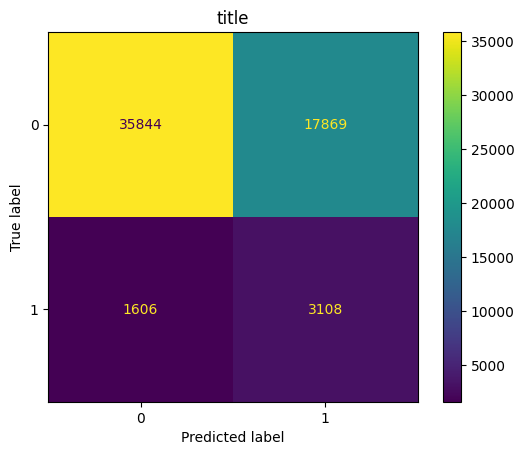

In [41]:
forest = RandomForestClassifier(
    max_depth=6, n_jobs=-1, class_weight="balanced", random_state=42
)
X_train_tf_rf = X_train_tf.fillna(-100_000_000)
X_valid_tf_rf = X_valid_tf.fillna(-100_000_000)

forest.fit(X_train_tf_rf, y_train)
y_pred = forest.predict(X_valid_tf_rf)

functions.plot_metrics(y_valid, y_pred)
plt.title("title")
plt.show()

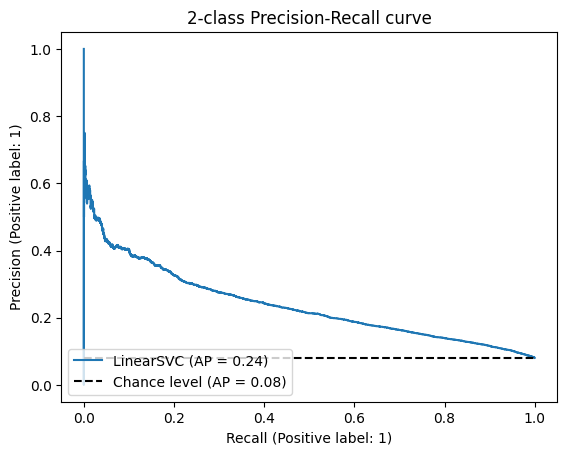

In [29]:
model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=500,
    learning_rate=0.1,
    early_stopping_rounds=50,
    seed=42,
    random_state=42,
)
model.fit(
    X_train_tf,
    y_train,
    eval_set=[(X_valid_tf, y_valid)],
    verbose=0,
)
disp = PrecisionRecallDisplay.from_estimator(
    model, X_valid_tf, y_valid, name="XGBoost", plot_chance_level=True
)
_ = disp.ax_.set_title("XGBoost Precision-Recall curve")
plt.legend(loc=1)
sns.despine()

              precision    recall  f1-score   support

           0       0.96      0.72      0.83     53713
           1       0.17      0.66      0.27      4714

    accuracy                           0.72     58427
   macro avg       0.57      0.69      0.55     58427
weighted avg       0.90      0.72      0.78     58427



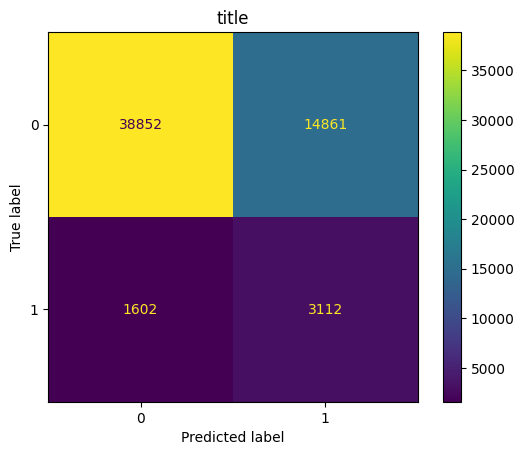

In [46]:
y_pred_proba = model.predict_proba(X_valid_tf)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba[:, 1])
RF_RECALL = 0.66
precision = precision[:-1]
recall = recall[:-1]
selected_thresh = thresholds[recall >= RF_RECALL].max()

y_pred = (y_pred_proba[:, 1] >= selected_thresh).astype(int)

functions.plot_metrics(y_valid, y_pred)
plt.title("title")
plt.show()

[20:12:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


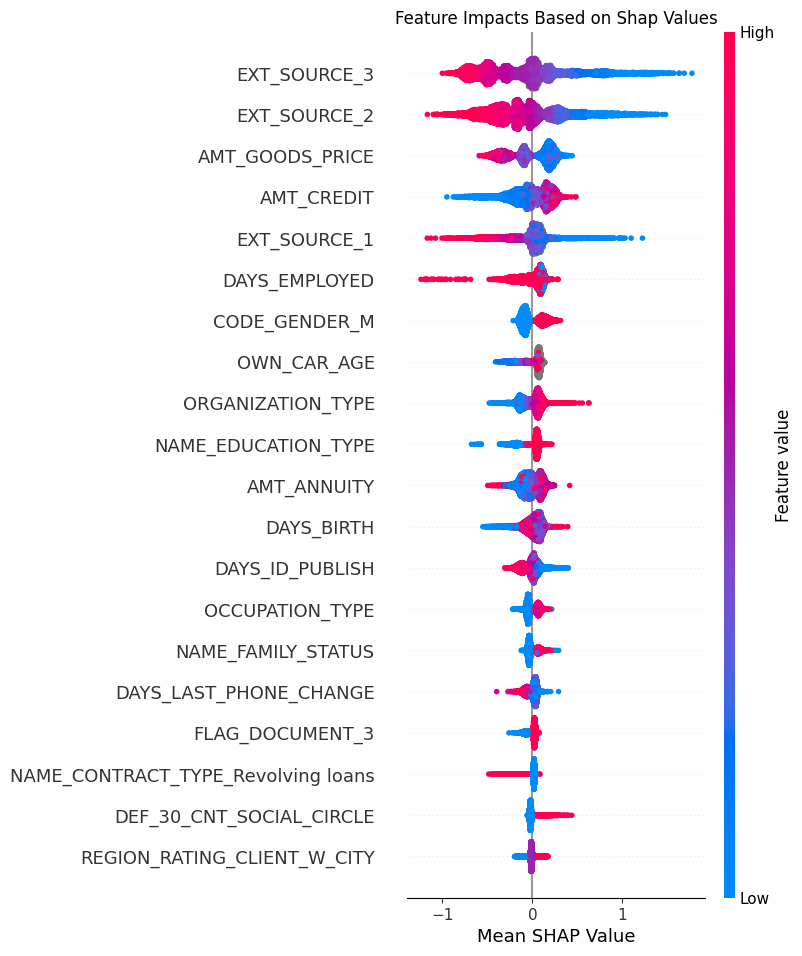

In [31]:
X_valid_tf_sample = X_valid_tf.sample(10000, random_state=42)
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_valid_tf_sample)

shap.summary_plot(shap_vals, X_valid_tf_sample, show=False)
plt.title("Feature Impacts Based on Shap Values")
plt.xlabel("Mean SHAP Value")
plt.show()

#### Add Bureau Aggregations

In [74]:
aggregates_bur = pd.read_parquet(r"data\train\aggregates_bur.parquet", engine="pyarrow")

In [75]:
BUR_DAYS_COLUMNS = ["BUR_DAYS_CREDIT_min", "BUR_DAYS_CREDIT_mean"]
aggregates_bur_days_tf = aggregates_bur.copy()
aggregates_bur_days_tf[BUR_DAYS_COLUMNS] = aggregates_bur[BUR_DAYS_COLUMNS] * -1

In [76]:
df_merged = df_app_days_tf.join(aggregates_bur_days_tf, on="SK_ID_CURR")

In [81]:
passthrough_features = (
    constants.BINARY_COLUMNS_PASSTHROUGH
    + constants.CONTINUOUS_COLUMNS
    + constants.ORDINAL_COLUMNS
    + aggregates_bur.columns.to_list()
)
preprocessor = ColumnTransformer(
    [
        ("binary_pipe", binary_pipe, binary_features),
        ("target_pipe", target_pipe, target_features),
        ("passthrough", "passthrough", passthrough_features),
        ("drop", "drop", constants.DROP_COLUMNS),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [82]:
df_train, df_valid = train_test_split(
    df_merged, test_size=0.2, stratify=df_merged["TARGET"], random_state=42
)
X_train = df_train.drop(columns="TARGET")
y_train = df_train["TARGET"]
X_valid = df_valid.drop(columns="TARGET")
y_valid = df_valid["TARGET"]

X_train_tf = preprocessor.fit_transform(X_train, y_train)
X_valid_tf = preprocessor.transform(X_valid)

              precision    recall  f1-score   support

           0       0.96      0.68      0.79     53713
           1       0.15      0.66      0.25      4714

    accuracy                           0.68     58427
   macro avg       0.55      0.67      0.52     58427
weighted avg       0.89      0.68      0.75     58427



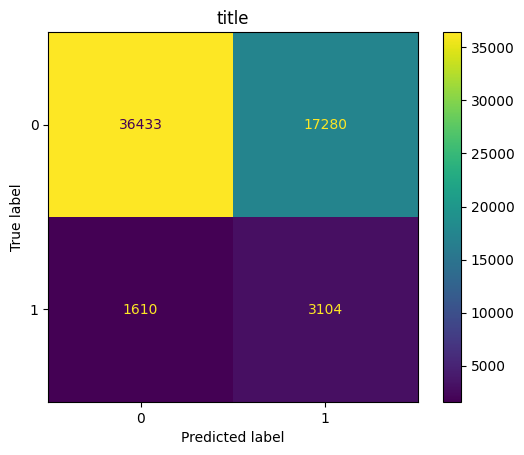

In [83]:
forest = RandomForestClassifier(
    max_depth=6, n_jobs=-1, class_weight="balanced", random_state=42
)
X_train_tf_rf = X_train_tf.fillna(-100_000_000)
X_valid_tf_rf = X_valid_tf.fillna(-100_000_000)

forest.fit(X_train_tf_rf, y_train)
y_pred = forest.predict(X_valid_tf_rf)

functions.plot_metrics(y_valid, y_pred)
plt.title("title")
plt.show()

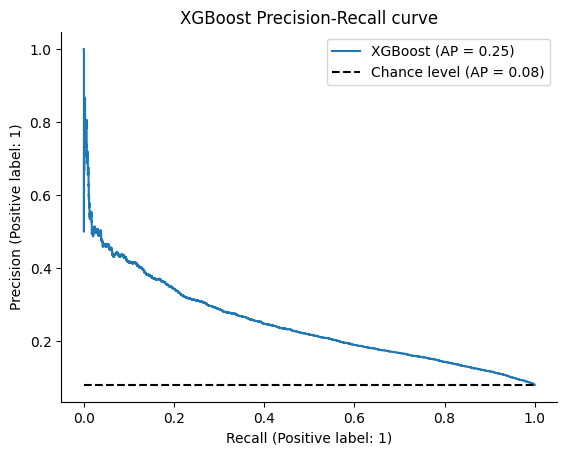

In [84]:
model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=500,
    learning_rate=0.1,
    early_stopping_rounds=50,
    seed=42,
    random_state=42,
)
model.fit(
    X_train_tf,
    y_train,
    eval_set=[(X_valid_tf, y_valid)],
    verbose=0,
)
disp = PrecisionRecallDisplay.from_estimator(
    model, X_valid_tf, y_valid, name="XGBoost", plot_chance_level=True
)
_ = disp.ax_.set_title("XGBoost Precision-Recall curve")
plt.legend(loc=1)
sns.despine()

              precision    recall  f1-score   support

           0       0.96      0.73      0.83     53713
           1       0.18      0.66      0.28      4714

    accuracy                           0.72     58427
   macro avg       0.57      0.69      0.55     58427
weighted avg       0.90      0.72      0.78     58427



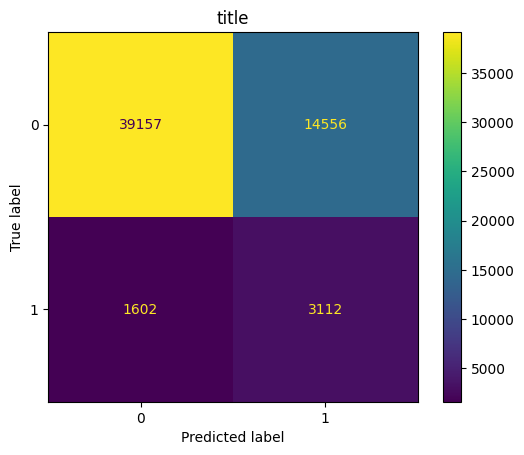

In [85]:
y_pred_proba = model.predict_proba(X_valid_tf)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba[:, 1])
RF_RECALL = 0.66
precision = precision[:-1]
recall = recall[:-1]
selected_thresh = thresholds[recall >= RF_RECALL].max()

y_pred = (y_pred_proba[:, 1] >= selected_thresh).astype(int)

functions.plot_metrics(y_valid, y_pred)
plt.title("title")
plt.show()

[21:01:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


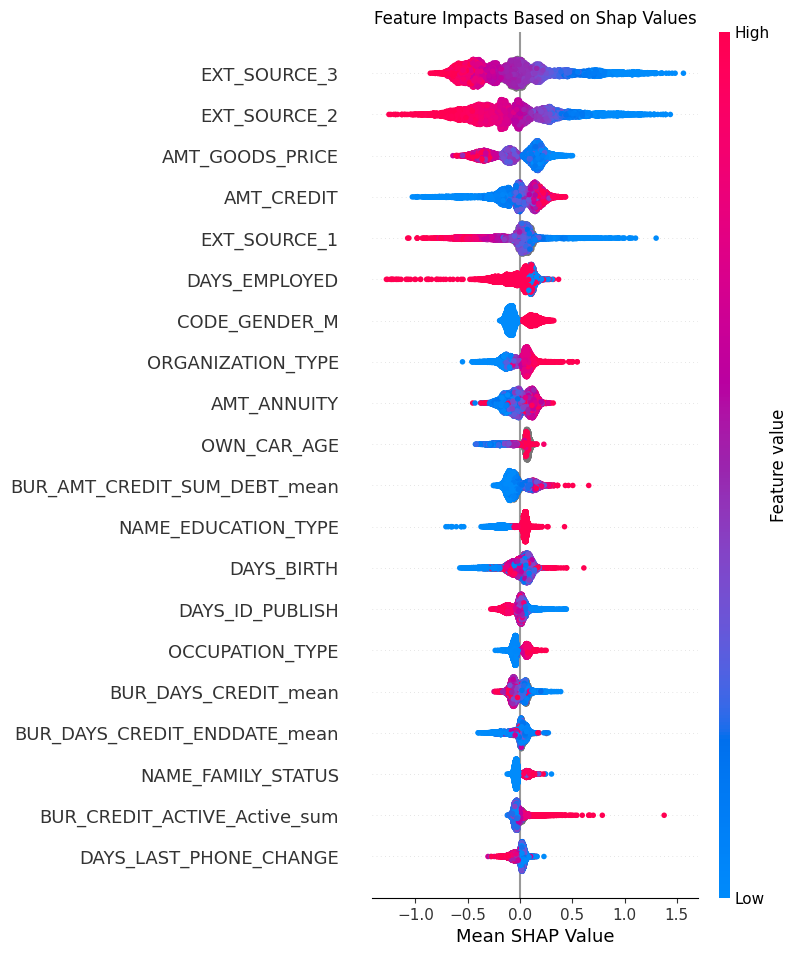

In [87]:
X_valid_tf_sample = X_valid_tf.sample(10000, random_state=42)
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_valid_tf_sample)

shap.summary_plot(shap_vals, X_valid_tf_sample, show=False)
plt.title("Feature Impacts Based on Shap Values")
plt.xlabel("Mean SHAP Value")
plt.show()